# scikit_neuralnetwork

In [1]:
from __future__ import division
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sknn.mlp                 import Classifier, Layer

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [22]:
SEED   = 97
scale  = True 
minmax = False
norm   = False
nointercept = True
engineering = True

N_CLASSES = 2

submission_filename = "../submissions/submission_scikit_nn.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [15]:
%%time

random.seed(SEED)

clf_layers = [
              Layer(type = 'Rectifier', name         = 'hidden', 
                                        units        = 200,
                                        weight_decay = None,
                                        pieces       = None,
                                        dropout      = None),
    
              Layer(type = 'Softmax',   name         = 'output')
             ]

clf = Classifier(layers            = clf_layers,
                 learning_rate     = 0.01,
                 learning_rule     = 'momentum',
                 learning_momentum = 0.9,
                 loss_type         = u'mse',
                 mutator           = None,    # data augmentation function
                 
                 regularize        = None,
                 weight_decay      = None,
                 dropout_rate      = None,
                 
                 batch_size        = 25,
                 
                 valid_size        = 0.1,    
                 valid_set         = None,
                 
                 n_stable          = 10,      # early stopping after ...
                 f_stable          = 0.001,   # validation error change threshold
                 n_iter            = 100,     # max epochs
                 
                 random_state      = SEED, 
                 debug             = False, 
                 verbose           = True) 



# param_grid = dict(learning_rate = [0.0001, 0.001, 0.003, 0.01],
#                   learning_rule = ['momentum', 'nesterov'],
#                   batch_size    = [1, 10, 100],
                  
#                   hidden__units = [10, 100, 500, 750],
#                   hidden__type  = ['Rectifier', 'Sigmoid', 'Tanh'])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV)

# grid_clf.fit(X_train.values.astype(np.float32), y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(grid_clf.best_score_))

# clf = grid_clf.best_estimator_




clf_params =  {'learning_rate': 0.01, 
               'learning_rule': 'nesterov', 
               'hidden__type': 'Rectifier', 
               'batch_size': 10, 
               'hidden__units': 100,
               'valid_size': None,
               'valid_set': None}
clf.set_params(**clf_params)
clf.fit(X_train.values.astype(np.float32), y_train)

CPU times: user 1.29 s, sys: 4 ms, total: 1.3 s
Wall time: 1.29 s


In [18]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

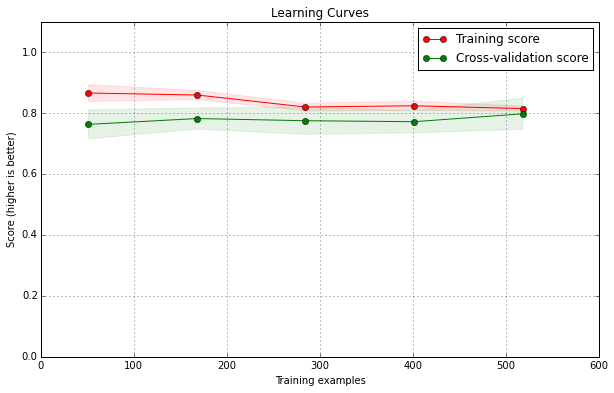

In [16]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = 'Learning Curves', 
                    X           = X_train.values.astype(np.float32), 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StatifiedCV, 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [17]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train.values.astype(np.float32), 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = -1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 172 ms, sys: 56 ms, total: 228 ms
Wall time: 3.71 s


[[396  42]
 [ 75  63]]


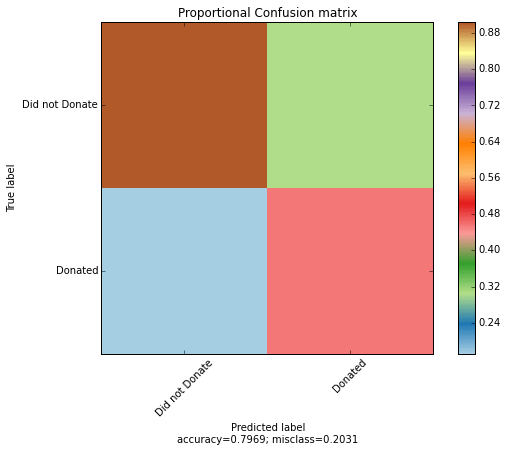

Accuracy 0.7969, mis-class rate 0.2031


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

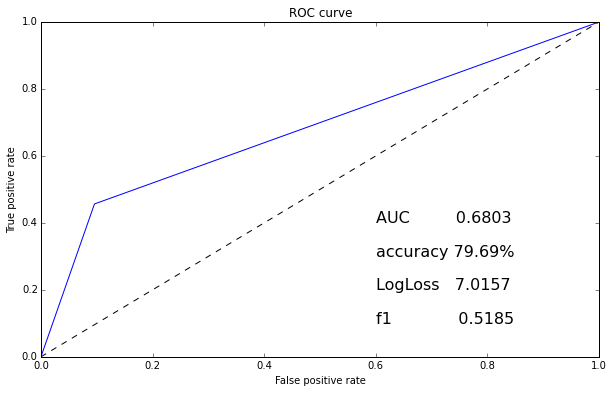

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

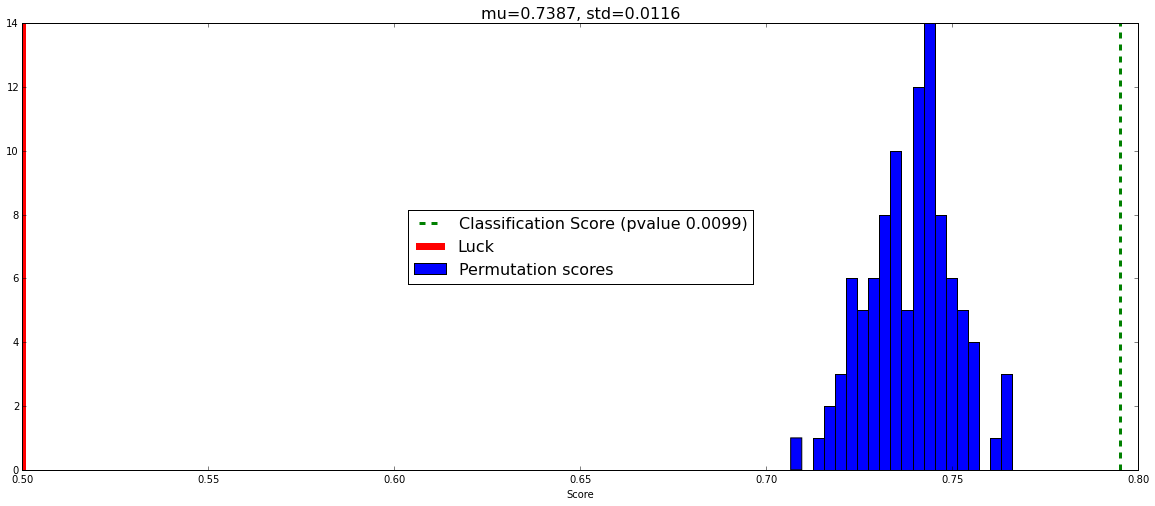

CPU times: user 10.1 s, sys: 136 ms, total: 10.2 s
Wall time: 4min 6s


In [20]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = -1) 
# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)


plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')

ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.title('mu={:.4f}, std={:.4f}'.format(mu,std), fontsize=20)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

In [23]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

scikit_nn                  ,        ,   0.7969 ,  7.0157 , 0.6803 , 0.5185 , 0.7387 , 0.0116


# Predict the leaderboard score with linear regression

In [24]:
# load the R extension
%load_ext rpy2.ipython

# see http://ipython.readthedocs.org/en/stable/config/extensions/index.html?highlight=rmagic
# see http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic

clear all but functions rm(list = setdiff(ls(), lsf.str()))
R functions in Dropbox:
 [1] "confusion.matrix_ROC.R" "eda.R"                  "knitr_settings.R"      
 [4] "lm_utilities.R"         "lsp.R"                  "matrix.power.R"        
 [7] "metrics.R"              "multiplot.R"            "my.special.functions.R"
[10] "NOT_IN.R"               "SDAFE.R"                "signOnToTwitter.R"     
[13] "source.dropbox.R"       "stem_plot.R"           
to load these functions: source("/home/george/Dropbox/R_functions/*.R")

To save graphical parameters: opar = par(no.readonly=TRUE)
to restore graphical parameters: par(opar)


In [25]:
# Import python variables into R
%R -i accuracy,logloss,AUC,f1,mu,std

In [26]:
%%R
# read in the scores.csv file and perform a linear regression with it using this process's variables

score_data = read.csv('../input/scores.csv')

lm.fit     = lm(leaderboard_score ~ accuracy + logloss + AUC + f1 + mu + std, 
                data      = score_data, 
                na.action = na.omit)

slm.fit = step(lm.fit, direction = "both", trace=0)

predicted_leaderboard_score = predict(object   = slm.fit, 
                                      newdata  = data.frame(accuracy,logloss,AUC,f1,mu,std),
                                      interval = "prediction", level = 0.99)

print(round(predicted_leaderboard_score,4))

     fit    lwr    upr
1 0.8708 -0.037 1.7786


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [27]:
clf.set_params(**clf_params)
clf.fit(X_train.values.astype(np.float32), y_train)

Classifier(batch_size=10, debug=False, dropout_rate=None, f_stable=0.001,
      hidden=<sknn.nn.Layer `Rectifier`: name='hidden', units=100>,
      layers=[<sknn.nn.Layer `Rectifier`: name='hidden', units=100>, <sknn.nn.Layer `Softmax`: name='output', units=2>],
      learning_momentum=0.9, learning_rate=0.01, learning_rule='nesterov',
      loss_type=u'mse', mutator=None, n_iter=100, n_stable=10,
      output=<sknn.nn.Layer `Softmax`: name='output', units=2>,
      random_state=97, regularize=None, valid_set=None, valid_size=None,
      verbose=True, weight_decay=None)

## Load the test data

In [28]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [30]:
y_pred = clf.predict(X_test.values.astype(np.float32)).ravel()
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test.values.astype(np.float32))
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[  3.69503021e-01   6.30496979e-01]
 [  9.12029505e-01   8.79704878e-02]
 [  9.53740537e-01   4.62594479e-02]
 [  8.28116298e-01   1.71883717e-01]
 [  3.24051440e-01   6.75948560e-01]
 [  6.41991720e-02   9.35800850e-01]
 [  8.63493204e-01   1.36506796e-01]
 [  9.82012033e-01   1.79879777e-02]
 [  9.99999881e-01   1.24267245e-07]
 [  9.88091528e-01   1.19084781e-02]]
[0.63049698, 0.087970488, 0.046259448, 0.17188372, 0.67594856, 0.93580085, 0.1365068, 0.017987978, 1.2426725e-07, 0.011908478]


# Create the submission file

In [31]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()